In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

import japanize_matplotlib
from fractions import Fraction

## 理想的な回路作成


In [2]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('$2^5$個のデータ')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.show()

### 動作の確認
5量子ビットのアルゴリズムを実装し、動作を確認する。

初期状態$|0 \cdots 0\rangle$を作成

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()
# print(state.get_vector())
# print(f'adf:{state.get_vector()[0]}')


次にアダマールゲートを作成する
$$
    H = \frac{1}{\sqrt(2)}(|0\rangle \langle 0| + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [4]:

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

このアダマールゲートを初期状態$|0 \cdots 0\rangle$に作用させる。

$$
|s\rangle = (H \otimes \cdots \otimes H)|0 \cdots 0\rangle \\

= \frac{1}{(\sqrt{2})^n}(| 0 \rangle + | 1 \rangle) \otimes \cdots \otimes (| 0 \rangle + | 1 \rangle)\\

= \frac{1}{(\sqrt{2})^n} (|00 \cdots 00 \rangle + | 00 \cdots 01 \rangle + \cdots + | 11 \cdots 10\rangle + |11 \cdots 11 \rangle) \\

|s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0}^{2^n - 1} |x\rangle
$$

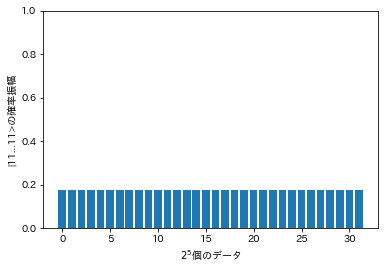

In [5]:
Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)
# print(f'初期：{state.get_vector()}')

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [6]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [7]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


print(fuga.get_vector())
最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [8]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

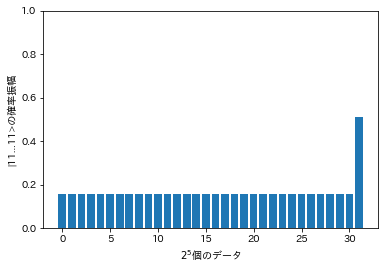

In [9]:
# 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

# U_s, U_wを作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state, nqubits)

In [10]:
nqubits = 5

# グローバーのアルゴリズム
def grover(nqubits, operate_time):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


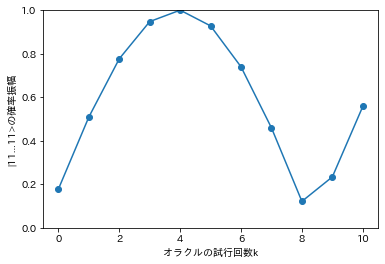

In [11]:
grover(5, 10)

## ランダムな初期状態の作成
次に、ランダムな初期状態を作成する。

In [12]:
# 量子状態と複素数の積を利用して計算

nqubits = 5
p = 0.5
state1 = QuantumState(nqubits)
state2 = QuantumState(nqubits)
state1.set_zero_state()
state2.set_zero_state()
# psi_0, psi_Haar = state
psi_0 = state1
psi_Haar = state2

Hadamard = make_Hadamard(nqubits)
# Hadamard.update_quantum_state(psi_0)
psi_0.set_zero_state()

psi_Haar.set_Haar_random_state()

# print(f'psi_0s norm: {psi_0.get_squared_norm()}, psi_Haars norm:{psi_Haar.get_squared_norm()}')
# (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
coef = np.sqrt(1 - p)
psi_0.multiply_coef(coef)
print(f'psi_0:{psi_0.get_squared_norm()}')

coef = np.sqrt(p)
psi_Haar.multiply_coef(coef)
print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

# (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
state = psi_0
state.add_state(psi_Haar)
print(f'state:{state.get_vector()}')
print(f'ノルム：{state.get_squared_norm()}')
print(state.get_qubit_count())

psi_0:0.5000000000000001
psi_Haar: 0.49999999999999994
state:[ 0.61764965-0.05686301j -0.06622892-0.00304323j -0.02220847+0.01913732j
  0.00286385+0.0165818j  -0.09352462+0.01642131j -0.0325943 +0.11570395j
  0.03258234+0.00119612j  0.07013504+0.03433732j  0.11041588-0.02375546j
  0.18496318+0.02506735j  0.03866059-0.11728209j -0.08200253+0.06655746j
 -0.06307195-0.00389528j -0.05392918-0.08318644j  0.1246649 +0.03935529j
  0.0456483 +0.07152497j  0.08193725+0.01502048j  0.18124067+0.16471811j
 -0.11315908+0.06030611j -0.13390734-0.06068339j -0.00149144-0.10487916j
  0.03990253-0.07752406j -0.10734476-0.05049623j -0.19079645-0.09583851j
  0.14895942-0.0672708j   0.00133314+0.00295314j -0.00795463-0.03805217j
  0.19786337-0.15722339j  0.06490096+0.08174008j  0.17387885+0.04442539j
  0.11669394+0.0057085j  -0.03168661+0.08594775j]
ノルム：0.8734885124466891
5


In [13]:
from qulacs import QuantumState
from qulacs.state import permutate_qubit, drop_qubit

In [14]:
def noisy_grover(nqubits, operate_time, dephasing_rate):
    # state = QuantumState(nqubits)
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    # psi_0, psi_Haar = state
    psi_0 = state1
    psi_Haar = state2

    # Hadamard = make_Hadamard(nqubits)
    # Hadamard.update_quantum_state(psi_0)
    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # print(f'psi_0s norm: {psi_0.get_squared_norm()}, psi_Haars norm:{psi_Haar.get_squared_norm()}')
    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    # state = QuantumState(nqubits)
    # state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        # show_distribution(state, nqubits)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('|11...11>の確率振幅')
    plt.ylim(0, 1)
    plt.plot(result, "o-")


In [15]:
def noisy_grover_graph_output(nqubits, operate_time, dephasing_rate):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    max_k = np.argmax(result)
    max_result_k.append(max_k + 1)
    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")

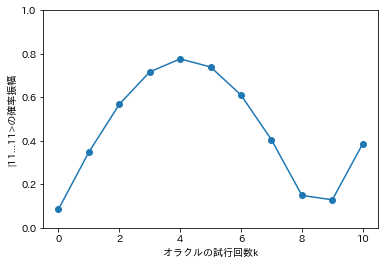

In [16]:
max_result_k = []
noisy_grover(5, 10, 0.5)

### 確率の変更
確率pが0〜10まででどうのような動きをするのか調べる

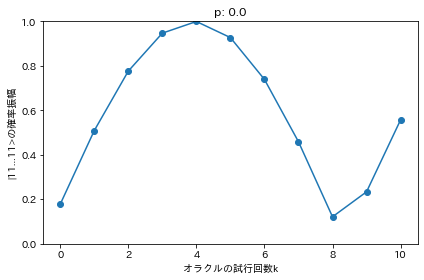

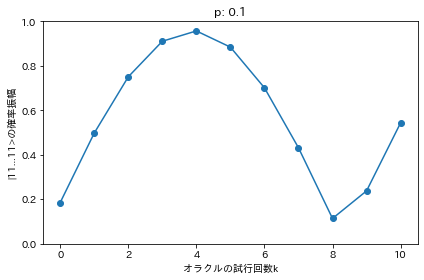

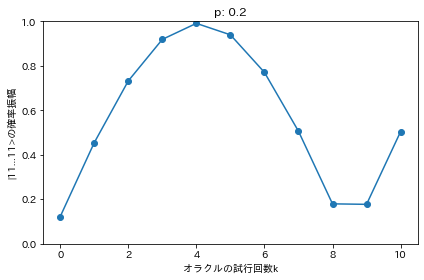

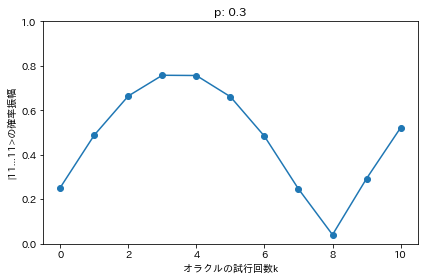

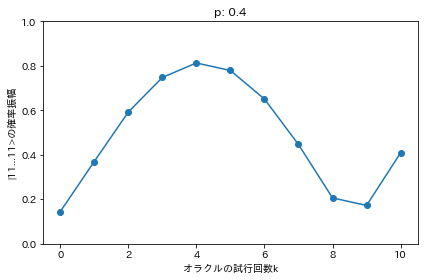

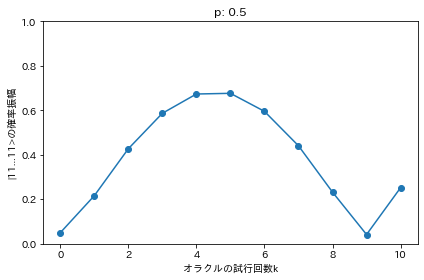

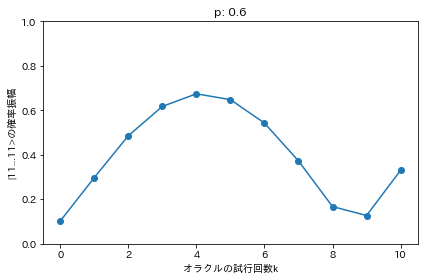

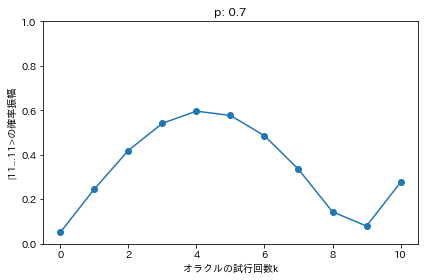

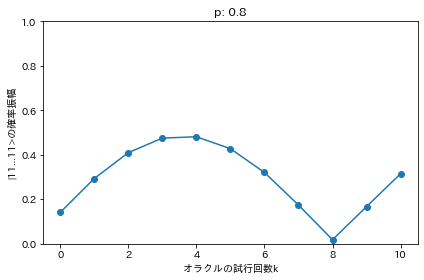

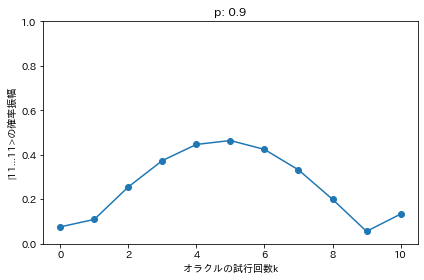

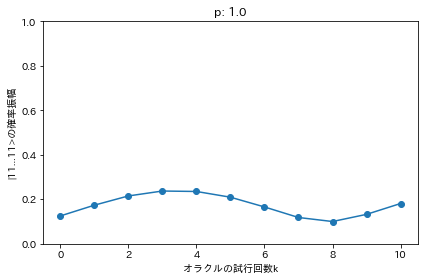

In [17]:
max_result_k = []
p = 10
for i in range(p + 1):
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'p: {i / 10}')

    noisy_grover(5, 10, i / 10)
    # noisy_grover(5, 10)

## 最大値に注目する(kに注目する)

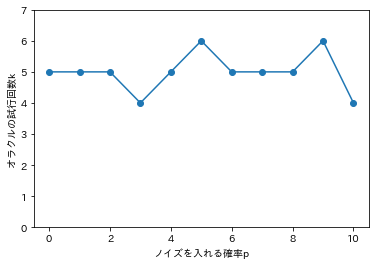

In [18]:
plt.plot(max_result_k, "-o")
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.ylim(0, np.max(max_result_k) + 1)
plt.show()

 サンプルを増やして、グラフ化してみる

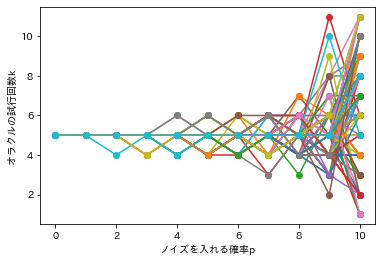

In [19]:
max_result = []
nqubits = 5

for i in range(100):
    max_result_k = []
    for j in range(p + 1):
        noisy_grover_graph_output(nqubits, 10, j / 10)
    max_result.append(max_result_k)

# print(max_result)
for i in max_result:
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('オラクルの試行回数k')
    plt.plot(i, "-o")

In [20]:
hoge = []
for i in range(p + 1):
    fuga = []
    for j in range(100):
        fuga.append(max_result[j][i])
    hoge.append(fuga)


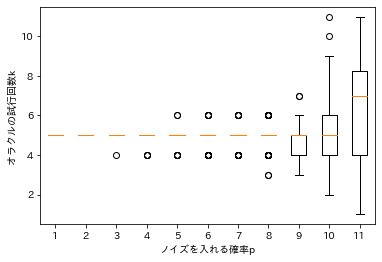

In [21]:

plt.boxplot(hoge)
plt.xlabel('ノイズを入れる確率p')
plt.ylabel('オラクルの試行回数k')
plt.show()

分散：0.0
分散：0.0
分散：0.009899999999999999
分散：0.038400000000000004
分散：0.0691
分散：0.1979
分散：0.14749999999999994
分散：0.42749999999999994
分散：0.5851
分散：2.1651
分散：8.1976


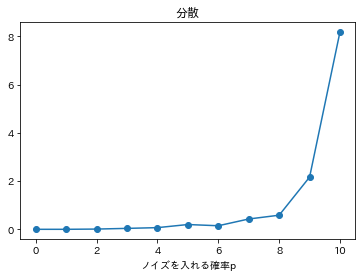

In [22]:
# 分散
var_array = []
for i in range(p + 1):
    v = np.var(hoge[i])
    var_array.append(v)
    print(f'分散：{v}')

plt.plot(var_array, "-o")
plt.title("分散")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

標準偏差:0.0
標準偏差:0.0
標準偏差:0.09949874371066199
標準偏差:0.19595917942265426
標準偏差:0.2628687885618983
標準偏差:0.4448595283907045
標準偏差:0.3840572873934303
標準偏差:0.6538348415311009
標準偏差:0.7649182962905253
標準偏差:1.471427877947132
標準偏差:2.8631451238105274


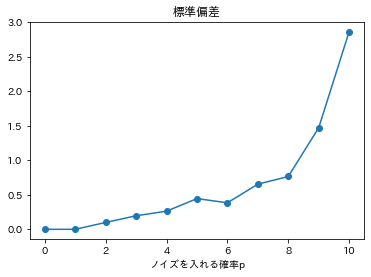

In [23]:
# 標準偏差
std_array = []

for i in range(p + 1):
    std = np.std(hoge[i])
    std_array.append(std)
    print(f'標準偏差:{std}')

plt.plot(std_array, "-o")
plt.title("標準偏差")
plt.xlabel('ノイズを入れる確率p')
# plt.ylabel('')
plt.show()

## k = 4の時に注目する

In [24]:
k_array = []
def noisy_grover_graph_output_k(nqubits, operate_time, dephasing_rate, k):
    state1 = QuantumState(nqubits)
    state2 = QuantumState(nqubits)
    state1.set_zero_state()
    state2.set_zero_state()
    psi_0 = state1
    psi_Haar = state2

    psi_0.set_zero_state()

    psi_Haar.set_Haar_random_state()

    # (√(1- p)|psi_0> と　(√(p)|psi_Haar>)を作成
    coef = np.sqrt(1 - dephasing_rate)
    psi_0.multiply_coef(coef)
    # print(f'psi_0:{psi_0.get_squared_norm()}')

    coef = np.sqrt(dephasing_rate)
    psi_Haar.multiply_coef(coef)
    # print(f'psi_Haar: {psi_Haar.get_squared_norm()}')

    # (√(1- p)|psi_0> + √(p)|psi_Haar> を作成
    state = psi_0
    state.add_state(psi_Haar)

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(result)
    for k in range(operate_time):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)


    # max_k = np.argmax(result)
    k_array.append(result[3])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    # plt.plot(np.arange(1, 30+1), result, "o-")
    # plt.plot(result, "o-")


In [25]:
nqubits = 5
k = 4
k_array = []
for i in range(p + 1):
    noisy_grover_graph_output_k(nqubits, 10, i / 10, k)

print(k_array)

[0.9470673343724091, 0.8497191732532259, 0.8296059740539574, 0.8474844937945509, 0.6534425868591006, 0.6761183202693384, 0.533531842230372, 0.4458855479058155, 0.22147552029621626, 0.46955912236184905, 0.14229422713041046]


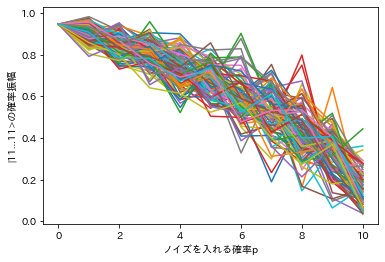

In [26]:
max_result = []
nqubits = 5
k = 4

for i in range(100):
    k_array = []
    for j in range(p + 1):
        noisy_grover_graph_output_k(nqubits, 10, j / 10, k)
    max_result.append(k_array)

# print(max_result)
for i in max_result:
    plt.plot(i)
    plt.xlabel('ノイズを入れる確率p')
    plt.ylabel('|11...11>の確率振幅')

